In [1]:
import tensorflow as tf
import pathlib
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
data_dir = "frames"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

test_data_dir = "test_frames"
test_data_dir = pathlib.Path(test_data_dir)
test_image_count = len(list(test_data_dir.glob('*/*.jpg')))
print(test_image_count)

BATCH_SIZE = 32
IMG_HEIGHT = 720//2
IMG_WIDTH = 1280//2
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
VALIDATION_STEPS = np.ceil(test_image_count/BATCH_SIZE)

train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

24620
4406


Found 24620 images belonging to 8 classes.
Found 4406 images belonging to 1 classes.
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


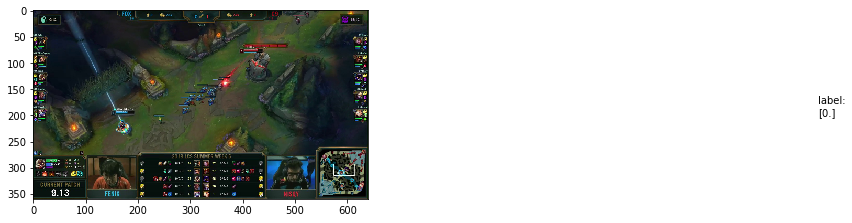

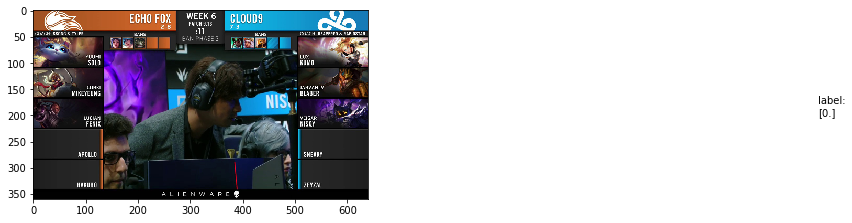

In [3]:
def label_map(datagen):
    for x in datagen:
        
        # Get the filenames that are shuffled
        current_index = ((datagen.batch_index-1) * datagen.batch_size)
        if current_index < 0:
            if datagen.samples % datagen.batch_size > 0:
                current_index = max(0,datagen.samples - datagen.samples % datagen.batch_size)
            else:
                current_index = max(0,datagen.samples - datagen.batch_size)
        index_array = datagen.index_array[current_index:current_index + datagen.batch_size].tolist()
        img_paths = [datagen.filepaths[idx] for idx in index_array]
        y = []
        for f in img_paths:
#             print(f)
            label = np.zeros(1)
            if "-h" in f:
                label[0] = 1
            y.append(label)
        yield x, np.array(y)

train_data_gen = train_image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode=None)
train_data_gen = label_map(train_data_gen)

test_data_gen = train_image_generator.flow_from_directory(directory=str(test_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode=None)
test_data_gen = label_map(test_data_gen)

data, labels = next(test_data_gen)
print(labels)
for i in range(2):
    plt.figure()
    plt.imshow(data[i])
    plt.text(1500,200,"label:\n" + str(labels[i]))

In [4]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 358, 638, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 179, 319, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 179, 319, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 177, 317, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 158, 64)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 88, 158, 64)       0         
_________________________________________

In [ ]:
mc = ModelCheckpoint('models/best_non_seq_model_seg.h5', monitor='val_f1_m', mode='max', verbose=1, save_best_only=True)

def weighted_binary_crossentropy(y_true, y_pred):

    # Original binary crossentropy (see losses.py):
    # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

    # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

    # Apply the weights because 0 is more common in true
    true_one_weight = 5
    true_zero_weight = 1
    true_weight_vector = y_true * true_one_weight + (1. - y_true) * true_zero_weight
    weighted_b_ce = true_weight_vector * b_ce

    pred_one_weight = 3
    pred_zero_weight = 1
    pred_weight_vector = y_pred * pred_one_weight + (1. - y_pred) * pred_zero_weight
    weighted_b_ce = pred_weight_vector * weighted_b_ce

    # Return the mean error
    return K.mean(weighted_b_ce)

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss=K.binary_crossentropy, 
              optimizer='adam',
               metrics=[
                       accuracy,
                       f1_m,
                       tf.keras.metrics.Recall(thresholds=0.5), 
                       tf.keras.metrics.Precision(thresholds=0.5)
                      ])

# 8 workers: 634 ms/step
# 4 workers: 645 ms/step

history = model.fit_generator(train_data_gen, 
                    epochs=20, 
                    validation_data=test_data_gen,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    callbacks=[mc],
                    use_multiprocessing=True,
                    workers=4,
                   )

Epoch 1/20
769/770 [============================>.] - ETA: 0s - loss: 0.1637 - acc: 0.9609WARNING:tensorflow:Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence` class.
Epoch 1/20
138/770 [====>.........................] - ETA: 4:28 - loss: 0.1490 - acc: 0.9651
Epoch 00001: val_acc improved from -inf to 0.96513, saving model to models/best_non_seq_model_seg.h5
770/770 [==============================] - 497s 645ms/step - loss: 0.1635 - acc: 0.9610 - val_loss: 0.1490 - val_acc: 0.9651
Epoch 2/20
103/770 [===>..........................] - ETA: 6:19 - loss: 0.2310 - acc: 0.9539